In [1]:
# This will train a CNN on the FULL Cats-v-dogs dataset
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [2]:
# Download data
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

--2020-09-01 04:06:51--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 2600:140a:6000:185::e59, 2600:140a:6000:190::e59, 23.64.56.228
Connecting to download.microsoft.com (download.microsoft.com)|2600:140a:6000:185::e59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M  21.2MB/s    in 29s     

2020-09-01 04:07:20 (27.5 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [3]:
# Extract files
local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

if os.path.exists("/tmp/PetImages/Cat/Thumbs.db"):
  os.remove("/tmp/PetImages/Cat/Thumbs.db")

if os.path.exists("/tmp/PetImages/Dog/Thumbs.db"):
  os.remove("/tmp/PetImages/Dog/Thumbs.db")

In [4]:
# Number of cat/dog images 
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12500
12500


In [5]:
# CREATE directory "cats-v-dogs" and subdirectories for 'cats' and 'dogs'
try:
    base_dir = '/tmp/cats-v-dogs/'
    os.mkdir(base_dir)
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [6]:
# Empty file: /tmp/PetImages/Cat/666.jpg & /tmp/PetImages/Dog/11702.jpg
os.remove ("/tmp/PetImages/Cat/666.jpg")
os.remove ("/tmp/PetImages/Dog/11702.jpg")

In [7]:
# SPLIT the data into training and testing
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = os.listdir(SOURCE)
    newlist=random.sample(files, len(files)) 
    split_point = round(len(newlist)*SPLIT_SIZE)
    for i,file in enumerate(newlist):
        fsize = os.path.getsize(os.path.join(SOURCE,file))
        if (fsize >0 and i < split_point):
            copyfile(os.path.join(SOURCE,file),os.path.join(TRAINING,file))
        elif (fsize >0 and i >= split_point):
            copyfile(os.path.join(SOURCE,file),os.path.join(TESTING,file))
        else:
            print("Empty file:",SOURCE,file)

CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

In [8]:
# Number of cat/dog images in training/testing folders
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11249
11249
1250
1250


In [9]:
# DEFINE a CNN model
model = tf.keras.models.Sequential([
    # The first 2D convolution with MaxPooling
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second 2D convolution with MaxPooling
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third 2D convolution with MaxPooling
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth 2D convolution with MaxPooling
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results 
    tf.keras.layers.Flatten(),
    # DNN with 512 neurons
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron with sigmoid function for binary classification
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# optimizer = "RMSprop" to adjust step size for weight update
model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

In [10]:
TRAINING_DIR = '/tmp/cats-v-dogs/training/'

# Data augmentation to reduce overfitting
train_datagen = ImageDataGenerator(rescale=1/255,
                                  rotation_range=40,
                                  width_shift_range=0.3,
                                  height_shift_range=0.3,
                                  shear_range=0.3,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

# Training: Image generator with a batch size of 50 
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                   batch_size=50,
                                                   class_mode='binary',
                                                   target_size=(300,300))

VALIDATION_DIR = '/tmp/cats-v-dogs/testing/'
validation_datagen = ImageDataGenerator(rescale=1/255)

# Testing: Image generator with a batch size of 50 
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                   batch_size=50,
                                                   class_mode='binary',
                                                   target_size=(300,300))

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [11]:
# Fit the model
history = model.fit_generator(train_generator,
                              epochs=5,
                              verbose=1,
                              validation_data=validation_generator)

#-----------------------------------------------------------
# There are some files with corrupt EXIF data, but that shouldn't affect the overall learning,
# given the size of the current dataset.
#-----------------------------------------------------------

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
 20/450 [>.............................] - ETA: 18:13 - loss: 2.6930 - acc: 0.5040

/Users/jimmy/opt/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/Users/jimmy/opt/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/Users/jimmy/opt/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/Users/jimmy/opt/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/Users/jimmy/opt/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:7

450/450 [==============================] - 1205s 3s/step - loss: 0.7792 - acc: 0.5813 - val_loss: 0.8053 - val_acc: 0.5592
Epoch 2/5
450/450 [==============================] - 6363s 14s/step - loss: 0.6269 - acc: 0.6488 - val_loss: 0.5684 - val_acc: 0.7204
Epoch 3/5
450/450 [==============================] - 3166s 7s/step - loss: 0.5918 - acc: 0.6899 - val_loss: 0.5579 - val_acc: 0.7224
Epoch 4/5
450/450 [==============================] - 11279s 25s/step - loss: 0.5607 - acc: 0.7110 - val_loss: 0.5140 - val_acc: 0.7648
Epoch 5/5
450/450 [==============================] - 2929s 7s/step - loss: 0.5402 - acc: 0.7321 - val_loss: 0.5403 - val_acc: 0.7388


Text(0.5, 1.0, 'Training and validation loss')

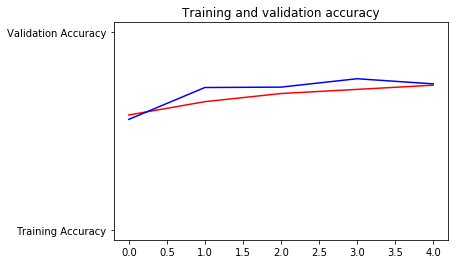

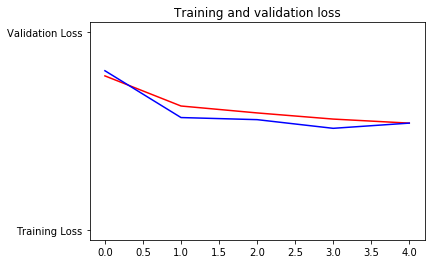

In [12]:
# Plot accuracy and loss per epoch
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Get the metrices of performance (accuracy & loss)
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs in an array

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure()
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")

plt.title('Training and validation loss')